## First Section of Code for dataset was taken from https://www.kaggle.com/code/fantineh/data-reader-and-visualization

# Imports

Import the required libraries.

In [38]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf

# Load the dataset

Enter the Unix glob file pattern of the data files.

Here we load the training data. All the data are stored in TensorFlow Record files.
Replace 'train' with 'eval' or 'test' to load the evaluation or testing data, respectively.

In [39]:
file_pattern = 'archive/next_day_wildfire_spread_train*'

Run the following three cells to define the required library functions for loading the data.

The first cell defines the name of the variables in the input files and the corrresponding data statistics. The statistics can be used for preprocessing the data. 

In [40]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

The following cell defines cropping functions for extracting regions of the desired size from the input data.

In [41]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

The following cell provides code for parsing the contents of the TensorFlow Record files. In addition to loading the data, it also offers functions for various preprocessing operations, such as clipping, rescaling, or normalizing the data.  

In [42]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

Load the dataset.

The data are stored as 64x64 km regions. For each data sample, we extract a random 32x32 km region. In the following function call, we do not clip, rescale or normalize the data. 

In [43]:
dataset = get_dataset(
      file_pattern,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=False)

TF Datasets are loaded lazily, so materialize the first batch of inputs and labels.

In [44]:
inputs, labels = next(iter(dataset))

2024-04-25 18:48:37.176641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [15]
	 [[{{node Placeholder/_0}}]]
2024-04-25 18:48:37.176876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [15]
	 [[{{node Placeholder/_0}}]]


# Start of Jonathan Stoschek Code

In [45]:
import numpy as np
from tqdm import tqdm

data_list = []
labels_list = []

for features, labels in tqdm(dataset):
    # Convert TensorFlow tensors to numpy arrays and append to lists
    data_list.append(features.numpy())
    labels_list.append(labels.numpy())

# Concatenate all data and labels at once outside the loop
data_array = np.concatenate(data_list, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

dataset_array = np.concatenate((data_array, labels_array), axis=3)

print(dataset_array.shape)

150it [00:02, 52.15it/s]


(14979, 64, 64, 13)


In [46]:
del dataset

In [47]:
print(dataset_array.max())

18.29444


In [48]:
from skimage.transform import resize

def downsample_images(images, new_shape=(32, 32)):
    # Determine the data type of the original images to use it later
    dtype = images.dtype

    # Initialize an empty array with the new shape and the same data type
    downsampled_images = np.zeros((images.shape[0], *new_shape, images.shape[3]), dtype=dtype)
    
    # Loop through each image with a tqdm progress bar
    for i in tqdm(range(images.shape[0]), desc="Downsampling images"):
        for c in range(images.shape[3]):
            # Resize the image and convert back to original data type
            downsampled_image = resize(images[i, :, :, c], new_shape, 
                                       order=1, # Bilinear interpolation (order=1) to prevent creating artifacts
                                       mode='reflect', 
                                       anti_aliasing=True, 
                                       preserve_range=True)
            downsampled_images[i, :, :, c] = downsampled_image.astype(dtype)
    
    return downsampled_images

# Apply the downsampling function
downsampled_images = downsample_images(dataset_array)

Downsampling images: 100%|██████████| 14979/14979 [00:18<00:00, 811.40it/s]


In [49]:
del dataset_array

In [50]:
import numpy as np

def rescale_images(images):

    # Initialize the output array with the same shape but int16 type
    rescaled_images = np.empty(images.shape, dtype=np.int16)

    # Process each channel individually
    for channel in range(11):
        # Extract the current channel
        channel_data = images[..., channel]

        # Compute the min and max values for the current channel
        min_val = channel_data.min()
        max_val = channel_data.max()

        # Normalize the channel data to [0, 1]
        normalized_data = (channel_data - min_val) / (max_val - min_val)

        # Scale to int16 range
        int16_max = 32767
        scaled_data = normalized_data * int16_max

        # Convert to int16 and store in the corresponding channel of the output array
        rescaled_images[..., channel] = scaled_data.astype(np.int16)
    
    # Scale the two fire mask layers individually
    rescaled_images[..., 11] = ((images[..., 11] + 1) * (32767 / 2)).astype(np.int16)
    rescaled_images[..., 12] = ((images[..., 12] + 1) * (32767 / 2)).astype(np.int16)

    return rescaled_images

downsampled_images = rescale_images(downsampled_images)


# Plotting function

Let's plot the data!

First we define the names for each of our variables.

In [51]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

Define some helper variables for the plot. 

In [52]:
# Number of rows of data samples to plot
n_rows = 5 
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks

original_bounds = [-1, -0.1, 0.001, 1]
scaled_bounds = [(x + 1) * (32767 / 2) for x in original_bounds]
BOUNDS = [0.0, 14745.15, 16399.88, 32767.0]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

[0.0, 14745.15, 16399.8835, 32767.0]


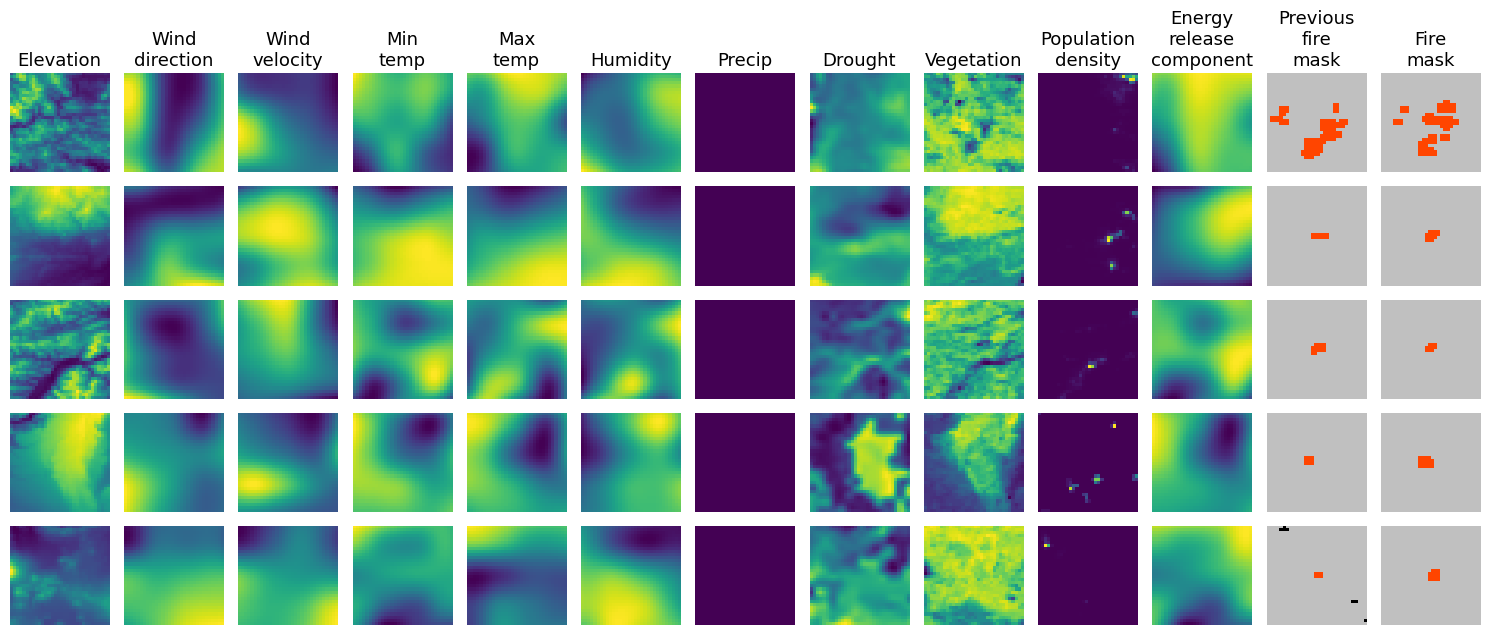

In [53]:
# The code in this cell is from Kaggle, but is edited by me

# Number of rows of data samples to plot
n_rows = 5 
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks

original_bounds = [-1, -0.1, 0.001, 1]
scaled_bounds = [(x + 1) * (32767 / 2) for x in original_bounds]
print(scaled_bounds)

BOUNDS = [0.0, 14745.15, 16399.88, 32767.0]

CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(downsampled_images[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(downsampled_images[i, :, :, -2], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(downsampled_images[i, :, :, -1], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

In [54]:
new_images = np.empty((14979, 32, 64, 3), dtype=np.int16)

# Create the new channels by concatenating the appropriate channels
new_images[:,:,:,0] = np.concatenate((downsampled_images[:,:,:,0], downsampled_images[:,:,:,8]), axis=2)  # First channel
new_images[:,:,:,1] = np.concatenate((downsampled_images[:,:,:,1], downsampled_images[:,:,:,2]), axis=2)  # Second channel
new_images[:,:,:,2] = np.concatenate((downsampled_images[:,:,:,11], downsampled_images[:,:,:,12]), axis=2) # Third channel

In [55]:
print(new_images.shape)

(14979, 32, 64, 3)


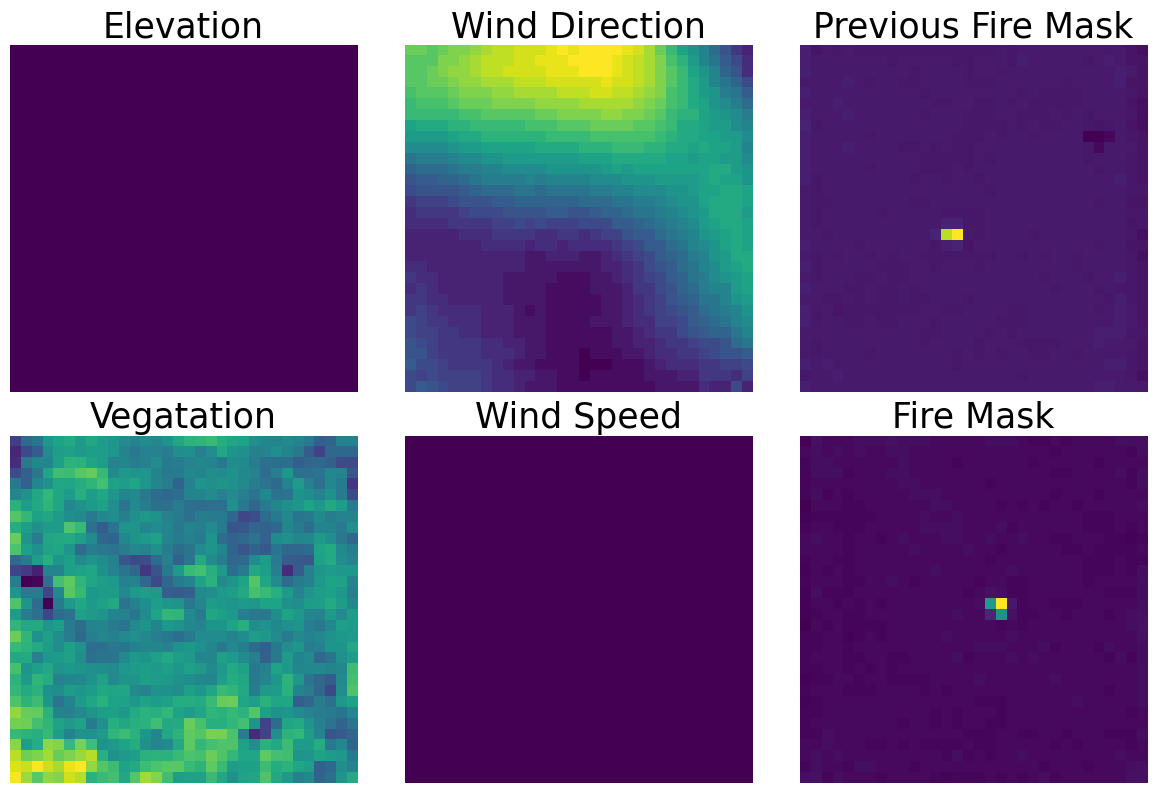

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from PIL import Image
import numpy as np

BOUNDS = [0.0, 114.75, 127.62749999999998, 255.0]
BOUNDS = [0.0, 113, 127.5, 255.0]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

# Open the image file
img = Image.open('interpolated/interpolate2-75.png')
# 3 is good

# img = Image.open('/Users/jstoschek/Downloads/Samples/sample-27.png')

# Convert the image to a NumPy array
image = np.array(img)

# Prepare the figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns

# Custom titles based on the original channels
titles = ['Elevation', 'Vegatation',
          'Wind Direction', 'Wind Speed',
          'Previous Fire Mask', 'Fire Mask']

# Loop through each channel and its two parts
for i in range(3):  # Three channels
    cmap_choice = 'viridis' if i < 3 else CMAP
    norm_choice = None if i < 3 else NORM

    axs[0, i].imshow(image[:, :32, i], cmap=cmap_choice, norm=norm_choice)
    axs[0, i].set_title(titles[2*i], fontsize=25)
    axs[0, i].axis('off')  # Turn off axis

    axs[1, i].imshow(image[:, 32:, i], cmap=cmap_choice, norm=norm_choice)
    axs[1, i].set_title(titles[2*i + 1], fontsize=25)
    axs[1, i].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


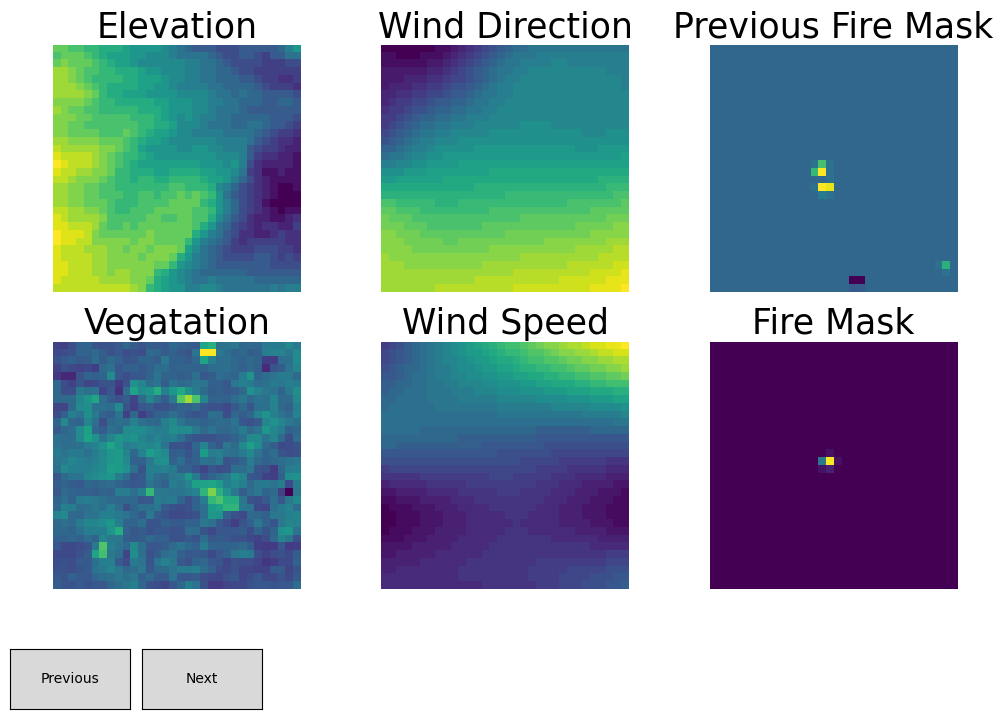

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from PIL import Image
import numpy as np
from matplotlib.widgets import Button

# Define color mapping and normalization
BOUNDS = [0.0, 113, 127.5, 255.0]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

# Titles for each sub-plot based on channels
titles = ['Elevation', 'Vegatation', 'Wind Direction', 'Wind Speed', 'Previous Fire Mask', 'Fire Mask']

# List of image file paths
image_files = [
    'WildFireImages1x2x3/image_00000.png',
    'WildFireImages1x2x3/image_00001.png',
    'WildFireImages1x2x3/image_00002.png',
    'WildFireImages1x2x3/image_00003.png',
    'WildFireImages1x2x3/image_00004.png',
    'WildFireImages1x2x3/image_00005.png',
    'WildFireImages1x2x3/image_00006.png',
    'WildFireImages1x2x3/image_00007.png',
    'WildFireImages1x2x3/image_00008.png',
    'WildFireImages1x2x3/image_00009.png',
]

# Current image index
current_image_index = 0

# Create figure and axes for image display and buttons
fig, axs = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns for channels
fig.subplots_adjust(bottom=0.2)

# Button for previous image
axprev = plt.axes([0.1, 0.05, 0.1, 0.075])
bprev = Button(axprev, 'Previous')

# Button for next image
axnext = plt.axes([0.21, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')

def update_image(index):
    global current_image_index
    current_image_index = index
    img = Image.open(image_files[current_image_index])
    image = np.array(img)

    for i in range(3):
        cmap_choice = 'viridis' if i < 3 else CMAP
        norm_choice = None if i < 3 else NORM

        axs[0, i].imshow(image[:, :32, i], cmap=cmap_choice, norm=norm_choice)
        axs[0, i].set_title(titles[2*i], fontsize=25)
        axs[0, i].axis('off')

        axs[1, i].imshow(image[:, 32:, i], cmap=cmap_choice, norm=norm_choice)
        axs[1, i].set_title(titles[2*i + 1], fontsize=25)
        axs[1, i].axis('off')
    
    plt.draw()

def prev_image(event):
    if current_image_index > 0:
        update_image(current_image_index - 1)

def next_image(event):
    if current_image_index < len(image_files) - 1:
        update_image(current_image_index + 1)

bprev.on_clicked(prev_image)
bnext.on_clicked(next_image)

# Initialize the first image
update_image(0)

plt.show()


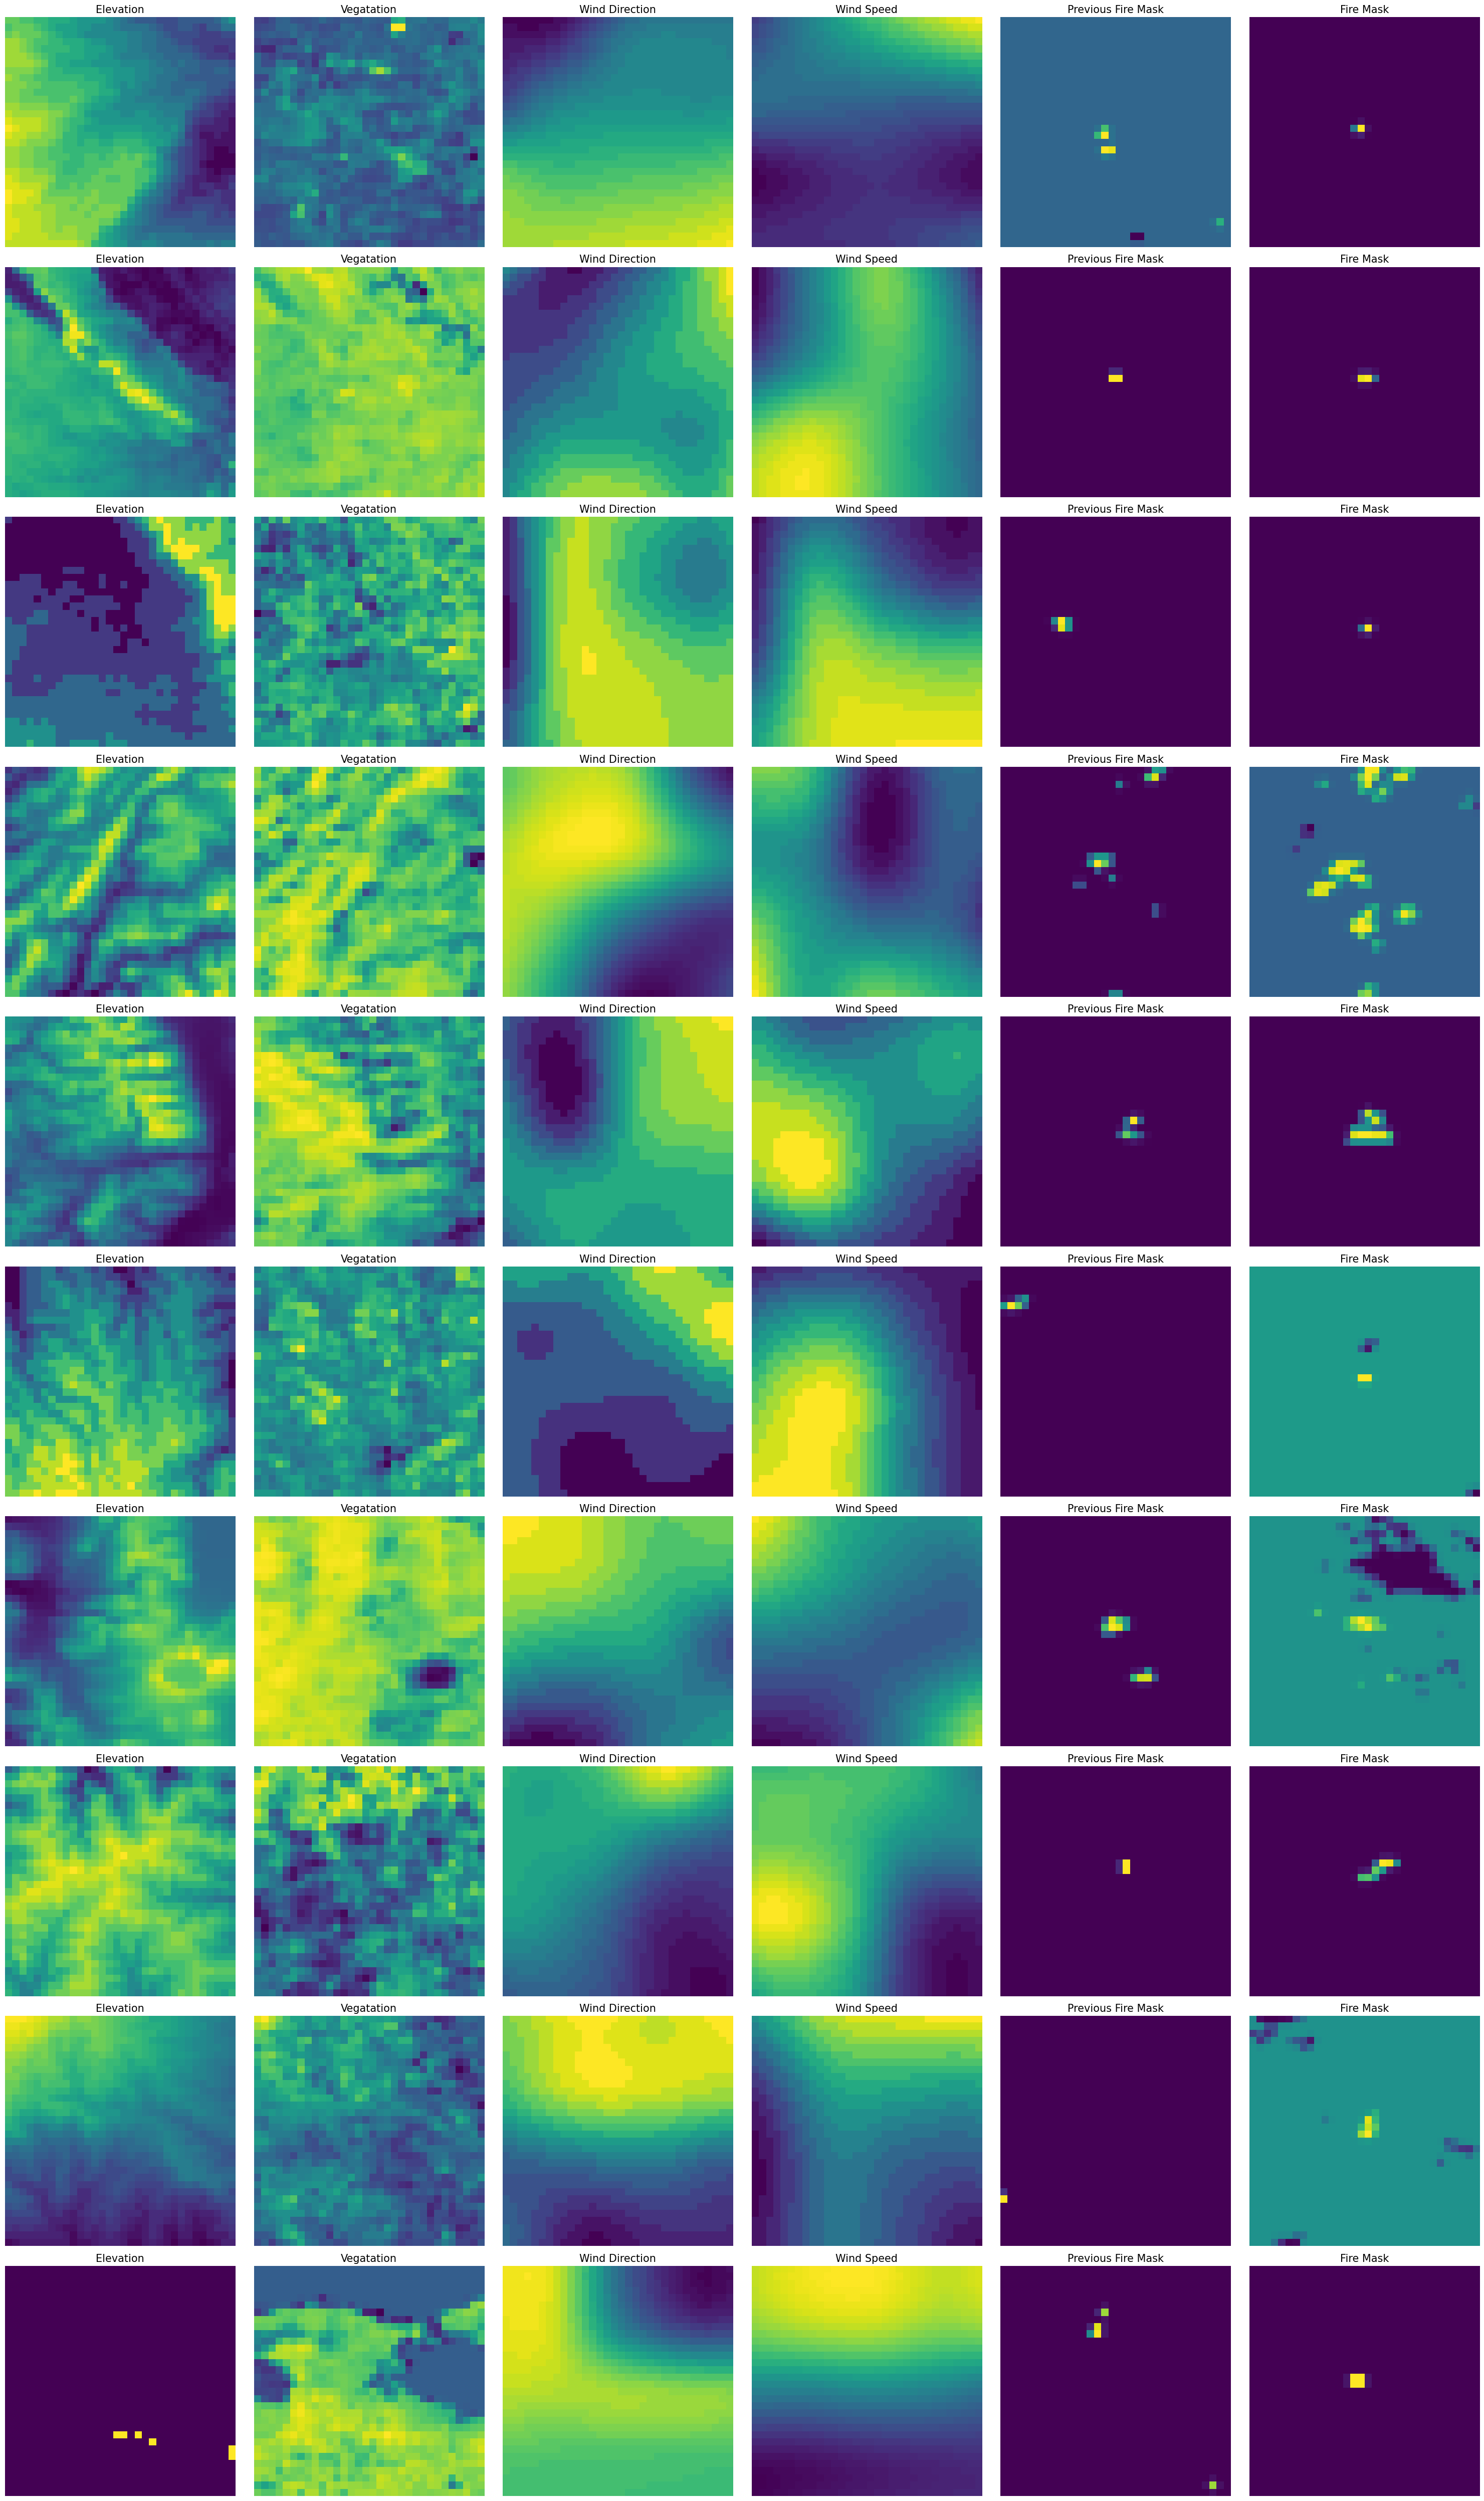

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from PIL import Image
import numpy as np

# Define color mapping and normalization
BOUNDS = [0.0, 113, 127.5, 255.0]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

# Titles for each sub-plot based on channels
titles = ['Elevation', 'Vegatation', 'Wind Direction', 'Wind Speed', 'Previous Fire Mask', 'Fire Mask']

# List of image file paths
image_files = [
    'WildFireImages1x2x3/image_00000.png',
    'WildFireImages1x2x3/image_00001.png',
    'WildFireImages1x2x3/image_00002.png',
    'WildFireImages1x2x3/image_00003.png',
    'WildFireImages1x2x3/image_00004.png',
    'WildFireImages1x2x3/image_00005.png',
    'WildFireImages1x2x3/image_00006.png',
    'WildFireImages1x2x3/image_00007.png',
    'WildFireImages1x2x3/image_00008.png',
    'WildFireImages1x2x3/image_00009.png',
]

# Create a figure to hold all subplots
fig, axs = plt.subplots(10, 6, figsize=(30, 50))  # 10 rows for images, 6 columns for channels

# Loop through each image file
for idx, file in enumerate(image_files):
    # Open and convert the image to a NumPy array
    img = Image.open(file)
    image = np.array(img)

    # Loop through each channel and its two parts
    for i in range(3):  # Assuming 3 channels, modify if there are more
        cmap_choice = 'viridis' if i < 3 else CMAP
        norm_choice = None if i < 3 else NORM

        # Display the upper half of the channel
        axs[idx, 2*i].imshow(image[:, :32, i], cmap=cmap_choice, norm=norm_choice)
        axs[idx, 2*i].set_title(titles[2*i], fontsize=15)
        axs[idx, 2*i].axis('off')

        # Display the lower half of the channel
        axs[idx, 2*i + 1].imshow(image[:, 32:, i], cmap=cmap_choice, norm=norm_choice)
        axs[idx, 2*i + 1].set_title(titles[2*i + 1], fontsize=15)
        axs[idx, 2*i + 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


(32, 64, 3)
(32, 32) (32, 32)


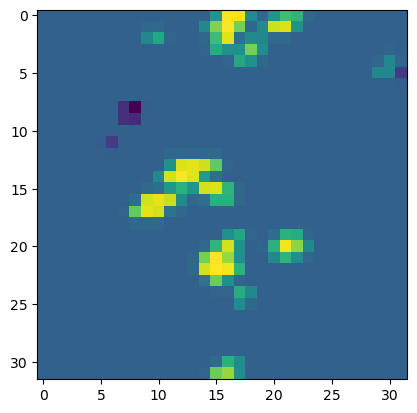

In [91]:
img = Image.open('WildFireImages1x2x3/image_00003.png')
image1 = np.array(img)
print(image.shape)
image2 = np.copy(image1)
prev_fire_mask = image1[:,0:32,2]
fire_mask = image2[:,32:64,2]
print(prev_fire_mask.shape, fire_mask.shape)
# plt.imshow(fire_mask)

image1[:,32:64,2] = prev_fire_mask
image2[:,0:32,2] = fire_mask

plt.imshow(image2[:,0:32,2])

interpolate_images = [image1, image2]

## Save Image

In [92]:
import numpy as np
import imageio
import os
from tqdm import tqdm

output_folder = 'interpolate_images'
os.makedirs(output_folder, exist_ok=True)

# Loop through each image in the array
for i, image in tqdm(enumerate(interpolate_images)):
    # Convert image to uint8 if not already (ensure proper scaling if necessary)
    if image.dtype != np.uint8:
        # Scale the data to 0-255 if it's not already in this range
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)

    # Save the image
    try:
        imageio.imwrite(f'{output_folder}/image_{i:05d}.png', image)
    except Exception as e:
        print(f"Failed to save image {i}: {e}")

print("Images have been saved.")

2it [00:00, 446.73it/s]

Images have been saved.


In [ ]:
import numpy as np
import imageio
import os
from tqdm import tqdm

output_folder = '1x2x3_images'
os.makedirs(output_folder, exist_ok=True)

# Loop through each image in the array
for i, image in tqdm(enumerate(new_images)):
    # Convert image to uint8 if not already (ensure proper scaling if necessary)
    if image.dtype != np.uint8:
        # Scale the data to 0-255 if it's not already in this range
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)

    # Save the image
    try:
        imageio.imwrite(f'{output_folder}/image_{i:05d}.png', image)
    except Exception as e:
        print(f"Failed to save image {i}: {e}")

print("Images have been saved.")


In [ ]:
import matplotlib.pyplot as plt
import os

# Ensure the output directory exists
output_dir = 'WildFireImages1x2x3'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each image in the array and save it
for i, image in enumerate(new_images[:2]):
    # Construct the file path
    file_path = os.path.join(output_dir, f'image_{i:05d}.png')
    
    # Save the image
    plt.imsave(file_path, image)

print("All images have been saved successfully.")